# **EDA for Stock1**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
from pykalman import KalmanFilter

In [29]:
stock1 = pd.read_csv("/Users/ayush/Documents/University/Year 03/Sem 01/DATA3888/Optiver-07/Data/individual_book_train/stock_1.csv")

In [30]:
stock1.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


In [31]:
print(stock1["stock_id"].unique())
del stock1["stock_id"]
stock1['time_id'] = pd.factorize(stock1['time_id'])[0] + 1

[1]


In [32]:
stock1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507532 entries, 0 to 1507531
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   time_id            1507532 non-null  int64  
 1   seconds_in_bucket  1507532 non-null  int64  
 2   bid_price1         1507532 non-null  float64
 3   ask_price1         1507532 non-null  float64
 4   bid_price2         1507532 non-null  float64
 5   ask_price2         1507532 non-null  float64
 6   bid_size1          1507532 non-null  int64  
 7   ask_size1          1507532 non-null  int64  
 8   bid_size2          1507532 non-null  int64  
 9   ask_size2          1507532 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 115.0 MB


In [33]:
stock1.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
count,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06,1.507532e+06
mean,1.919887e+03,2.973244e+02,9.996410e-01,1.000336e+00,9.994711e-01,1.000513e+00,1.400434e+02,1.426668e+02,1.313312e+02,1.348528e+02
std,1.108814e+03,1.733051e+02,4.356132e-03,4.369011e-03,4.356323e-03,4.382665e-03,1.634213e+02,1.588737e+02,1.771449e+02,1.786345e+02
min,1.000000e+00,0.000000e+00,9.374725e-01,9.381779e-01,9.369433e-01,9.383544e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,9.620000e+02,1.470000e+02,9.980202e-01,9.986284e-01,9.978551e-01,9.987874e-01,5.900000e+01,7.700000e+01,5.800000e+01,6.500000e+01
50%,1.918000e+03,2.960000e+02,9.997228e-01,1.000271e+00,9.995778e-01,1.000424e+00,1.010000e+02,1.010000e+02,1.000000e+02,1.000000e+02
75%,2.878000e+03,4.470000e+02,1.001302e+00,1.001891e+00,1.001147e+00,1.002056e+00,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02
max,3.830000e+03,5.990000e+02,1.049250e+00,1.063606e+00,1.049108e+00,1.064601e+00,2.089600e+04,2.100200e+04,2.089600e+04,3.532900e+04


## **TimeIDs and Buckets**

In [34]:
len(stock1["time_id"].unique())

3830

In [35]:
seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique().sort_values()
print(seconds_per_time_id)

time_id
3312    132
1094    134
1687    135
3578    138
2965    139
       ... 
3562    595
2311    595
3202    596
1710    597
315     599
Name: seconds_in_bucket, Length: 3830, dtype: int64


In [36]:
seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
expected_seconds = 600
missing_seconds = expected_seconds - seconds_per_time_id
high_missing_threshold = 0.5 * expected_seconds 
high_missing_time_ids = missing_seconds[missing_seconds > high_missing_threshold]
print("Time IDs with high number of missing seconds (more than 50% missing):")
print(high_missing_time_ids.sort_values(ascending=False))

Time IDs with high number of missing seconds (more than 50% missing):
time_id
3312    468
1094    466
1687    465
3578    462
2965    461
       ... 
3524    301
3549    301
2250    301
2103    301
3085    301
Name: seconds_in_bucket, Length: 937, dtype: int64


In [37]:
time_id_sample = 9186
seconds_present = stock1[stock1["time_id"] == time_id_sample]["seconds_in_bucket"]
missing = set(range(600)) - set(seconds_present)
print(f"Missing seconds in time_id {time_id_sample}:", sorted(missing))

Missing seconds in time_id 9186: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 2

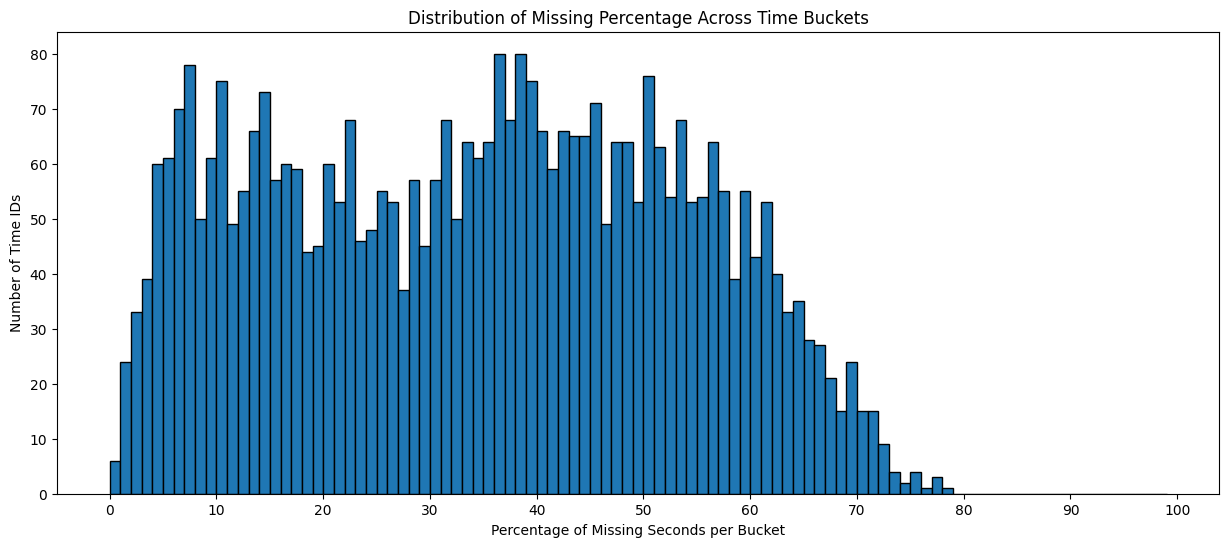

In [38]:

seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
expected_seconds = 600
missing_seconds = expected_seconds - seconds_per_time_id
missing_percentage = (missing_seconds / expected_seconds) * 100

plt.figure(figsize=(15, 6))
bins = np.arange(0, 100, 1)
plt.hist(missing_percentage, bins=bins, edgecolor='black')
plt.xlabel("Percentage of Missing Seconds per Bucket")
plt.ylabel("Number of Time IDs")
plt.title("Distribution of Missing Percentage Across Time Buckets")
plt.xticks(np.arange(0, 105, 10))
plt.show()

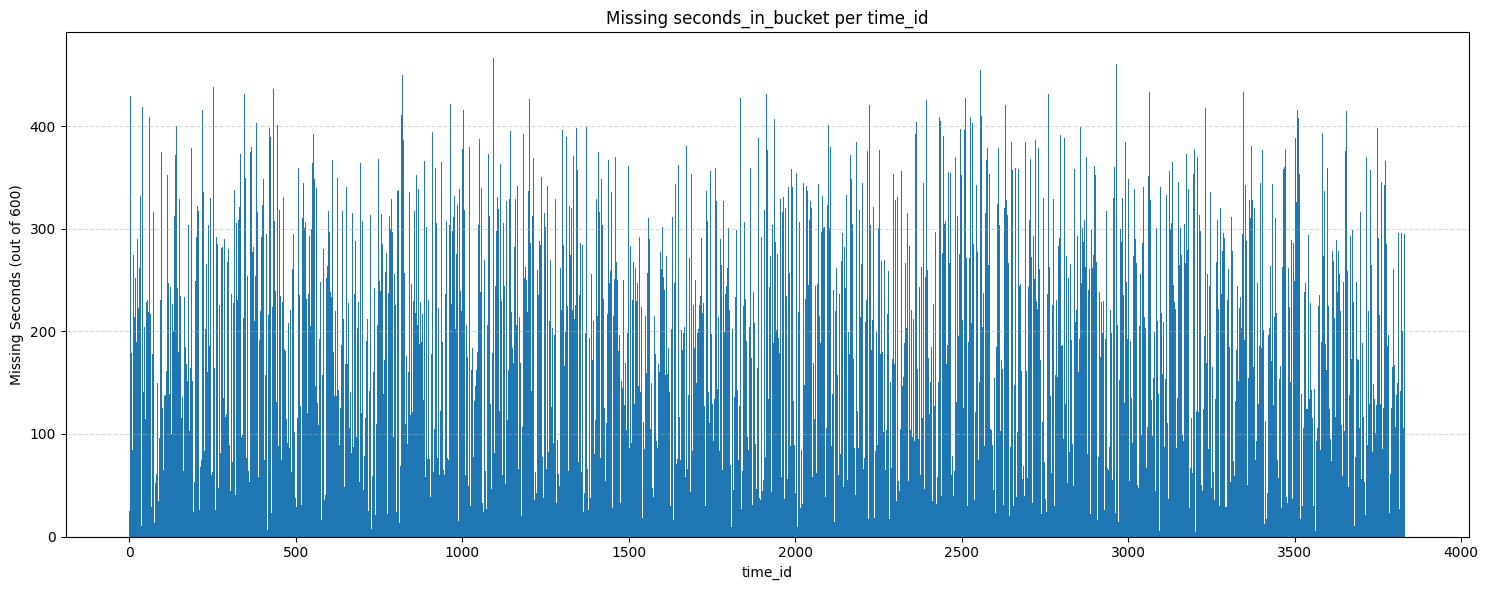

In [39]:
expected_seconds = set(range(600)) 
missing_counts = (
    stock1.groupby("time_id")["seconds_in_bucket"]
    .apply(lambda x: 600 - len(set(x)))
    .reset_index(name="missing_seconds")
)

plt.figure(figsize=(15, 6))
plt.bar(missing_counts["time_id"], missing_counts["missing_seconds"], width=1.0)
plt.xlabel("time_id")
plt.ylabel("Missing Seconds (out of 600)")
plt.title("Missing seconds_in_bucket per time_id")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

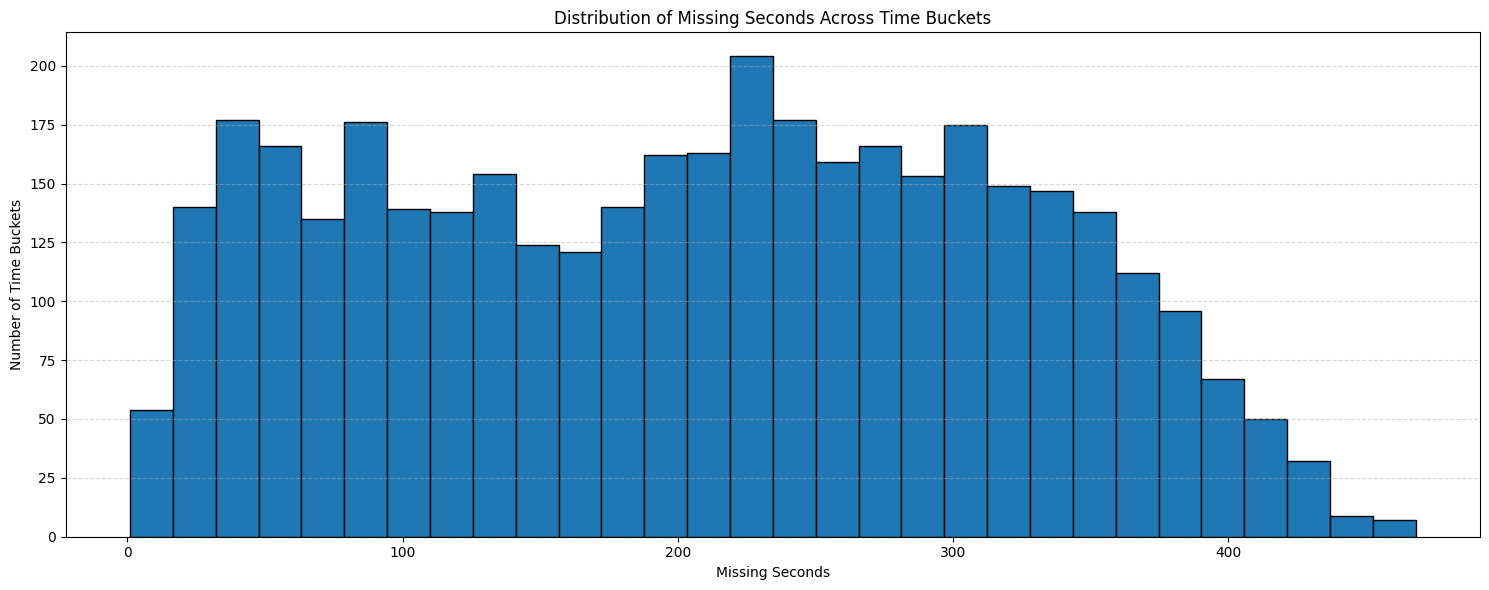

In [40]:
plt.figure(figsize=(15, 6))
plt.hist(missing_counts["missing_seconds"], bins=30, edgecolor='black')
plt.xlabel("Missing Seconds")
plt.ylabel("Number of Time Buckets")
plt.title("Distribution of Missing Seconds Across Time Buckets")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
df_copy = stock1.copy()
all_seconds = np.arange(0, 600)
time_ids = df_copy['time_id'].unique()
full_index = pd.MultiIndex.from_product([time_ids, all_seconds],names=['time_id', 'seconds_in_bucket'])
df_full = pd.DataFrame(index=full_index).reset_index()
df_merged = pd.merge(df_full, df_copy, on=['time_id', 'seconds_in_bucket'], how='left')
non_key_columns = [col for col in df_copy.columns if col not in ['time_id', 'seconds_in_bucket']]
df_merged['missing_indicator'] = df_merged[non_key_columns].isna().all(axis=1).astype(int)
df_merged

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,missing_indicator
0,1,0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0,0
1,1,1,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0,0
2,1,2,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0,0
3,1,3,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0,0
4,1,4,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2297995,3830,595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297996,3830,596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297997,3830,597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2297998,3830,598,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [42]:
def little_mcar_test(df, cols):
    """
    Perform Little's MCAR test on a DataFrame.
    
    Parameters:
      df   : DataFrame containing missing values.
      cols : List of numeric columns to include in the test.
      
    Returns:
      chi2_stat : The chi-squared test statistic.
      df_total  : Total degrees of freedom.
      p_value   : p-value for the test.
    """
    df_subset = df[cols]
    complete_data = df_subset.dropna()
    overall_mean = complete_data.mean()
    cov_matrix = complete_data.cov()

    missing_patterns = df_subset.isnull().astype(int).drop_duplicates()
    
    chi2_stat = 0.0
    df_total = 0
    
    for idx, pattern in missing_patterns.iterrows():
        mask = (df_subset.isnull().astype(int) == pattern).all(axis=1)
        subset = df_subset[mask]
        n = subset.shape[0]
        observed_vars = pattern[pattern == 0].index.tolist()
        if len(observed_vars) == 0:
            continue
        
        group_mean = subset[observed_vars].mean()
        delta = (group_mean - overall_mean[observed_vars]).values.reshape(-1, 1)
        cov_sub = cov_matrix.loc[observed_vars, observed_vars].values
        inv_cov = np.linalg.pinv(cov_sub)
        
        t_stat = n * (delta.T @ inv_cov @ delta)
        chi2_stat += t_stat[0, 0]
        df_total += len(observed_vars)
    
    p_value = stats.chi2.sf(chi2_stat, df_total)
    return chi2_stat, df_total, p_value

chi2, dof, pval = little_mcar_test(df_merged, ['missing_indicator'])
print("\nLittle's MCAR Test Results:")
print(f"Chi2 Statistic: {chi2:.3f}, Degrees of Freedom: {dof}, p-value: {pval:.3f}")


Little's MCAR Test Results:
Chi2 Statistic: 0.000, Degrees of Freedom: 1, p-value: 1.000


In [43]:
logit_model = smf.logit('missing_indicator ~ seconds_in_bucket', data=df_merged).fit(disp=False)
print("\nLogistic Regression Summary for Missing Indicator:")
print(logit_model.summary())


Logistic Regression Summary for Missing Indicator:
                           Logit Regression Results                           
Dep. Variable:      missing_indicator   No. Observations:              2298000
Model:                          Logit   Df Residuals:                  2297998
Method:                           MLE   Df Model:                            1
Date:                Tue, 15 Apr 2025   Pseudo R-squ.:               0.0002338
Time:                        12:24:24   Log-Likelihood:            -1.4787e+06
converged:                       True   LL-Null:                   -1.4791e+06
Covariance Type:            nonrobust   LLR p-value:                2.102e-152
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7090      0.003   -254.261      0.000      -0.714      -0.704
seconds_in_bucket     0.0002   8.02e-06     26.292      0.

In [44]:
pivot_table = df_merged.pivot(index='time_id', columns='seconds_in_bucket', values='missing_indicator')
pivot_table = pivot_table.fillna(0)
pivot_table['missing_rate'] = pivot_table.mean(axis=1)
seconds_columns = list(all_seconds)  
n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(pivot_table[seconds_columns])
pivot_table['cluster'] = clusters
cluster_summary = pivot_table.groupby('cluster')['missing_rate'].mean()
print("\nCluster Summary (Average Missing Rate by Cluster):")
print(cluster_summary)


Cluster Summary (Average Missing Rate by Cluster):
cluster
0     0.085829
1     0.559792
2     0.526667
3     0.666741
4     0.406858
5     0.588287
6     0.523810
7     0.612662
8     0.538099
9     0.326181
10    0.462451
11    0.546667
12    0.511000
13    0.548238
14    0.538141
15    0.508851
16    0.483333
17    0.486979
18    0.578333
19    0.521542
20    0.639822
21    0.590833
22    0.416245
23    0.209546
24    0.473788
25    0.497654
26    0.527523
27    0.476778
28    0.594111
29    0.524653
Name: missing_rate, dtype: float64


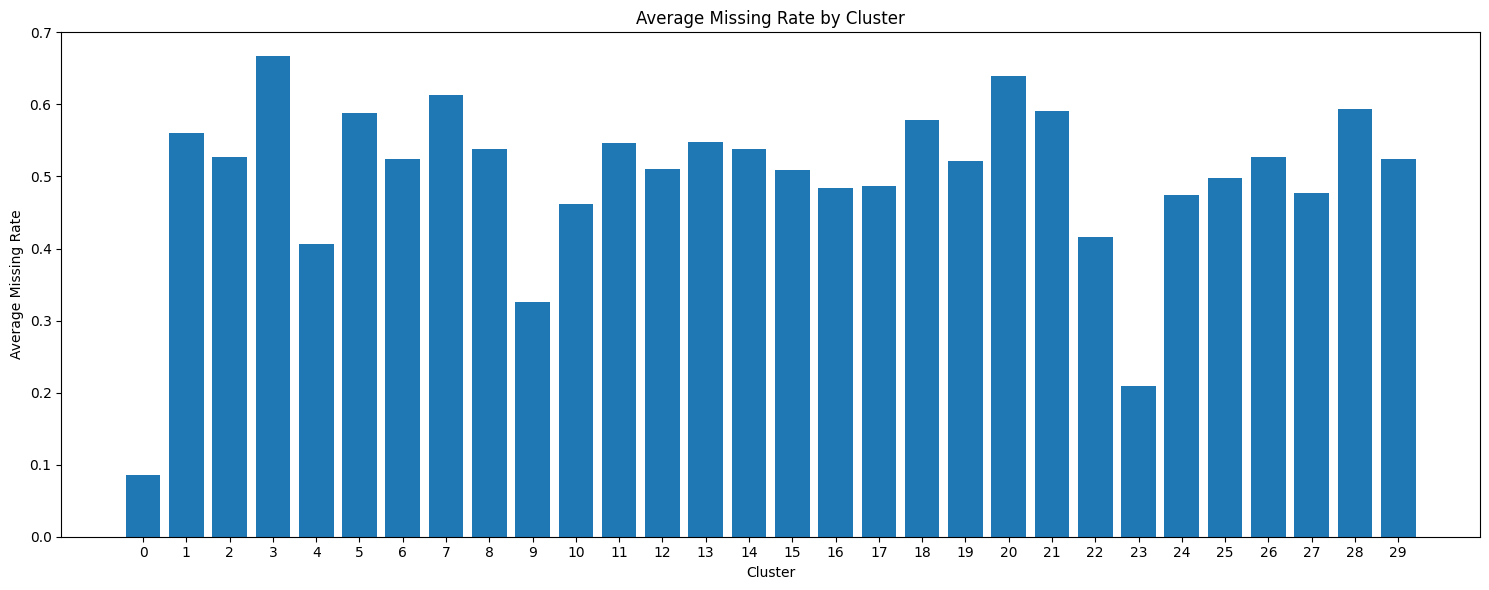

In [45]:
plt.figure(figsize=(15, 6))
plt.bar(cluster_summary.index.astype(str), cluster_summary.values)
plt.xlabel("Cluster")
plt.ylabel("Average Missing Rate")
plt.title("Average Missing Rate by Cluster")
plt.tight_layout()
plt.show()

In [46]:
del df_copy, df_merged

In [47]:
seconds_per_time_id = stock1.groupby("time_id")["seconds_in_bucket"].nunique()
expected_seconds = 600
missing_seconds = expected_seconds - seconds_per_time_id
missing_percentage = (missing_seconds / expected_seconds) * 100

# Low missing: <20%, Moderate missing: 20-50%, High missing: >50%
bucket_classification = pd.DataFrame({
    'time_id': missing_percentage.index,
    'missing_percentage': missing_percentage.values
})
bucket_classification['missing_category'] = pd.cut(
    bucket_classification['missing_percentage'],
    bins=[-1, 20, 50, 100],
    labels=['low', 'moderate', 'high']
)
bucket_classification

,time_id,missing_percentage,missing_category
0,1,4.166667,low
1,2,38.333333,moderate
2,3,41.166667,moderate
3,4,71.500000,high
4,5,62.166667,high
...,...,...,...
3825,3826,48.833333,moderate
3826,3827,17.666667,low
3827,3828,47.833333,moderate
3828,3829,27.666667,moderate


In [ ]:
def reindex_group(group):
    group = group.set_index('seconds_in_bucket').sort_index()
    complete_index = range(600)
    group = group.reindex(complete_index)
    group['time_id'] = group['time_id'].ffill()
    return group.reset_index().rename(columns={'index': 'seconds_in_bucket'})

df_complete = stock1.groupby('time_id', group_keys=False).apply(reindex_group)

/var/folders/0s/bt69j7tj0pd5rl5dzr4n6bth0000gn/T/ipykernel_1702/2575454638.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_complete = stock1.groupby('time_id', group_keys=False).apply(reindex_group)


In [53]:
df_complete

,seconds_in_bucket,time_id,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,0,1.0,1.000754,1.001542,1.000689,1.001607,1.0,25.0,25.0,100.0
1,1,1.0,1.000754,1.001673,1.000689,1.001739,26.0,60.0,25.0,100.0
2,2,1.0,1.000754,1.001411,1.000623,1.001476,1.0,25.0,25.0,125.0
3,3,1.0,1.000754,1.001542,1.000689,1.001607,125.0,25.0,126.0,36.0
4,4,1.0,1.000754,1.001476,1.000623,1.001542,100.0,100.0,25.0,25.0
...,...,...,...,...,...,...,...,...,...,...
595,595,3830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,596,3830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,597,3830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,598,3830.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Manual Feature Engineering**

In [49]:
stock1["midpoint"] = (stock1["ask_price1"] + stock1["bid_price1"]) / 2
stock1["bid_ask_spread"] = stock1["ask_price1"] - stock1["bid_price1"]
stock1["log_return"] = np.log(stock1["midpoint"]).diff()

In [50]:
print(stock1.head(n=10).to_string())

   time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  midpoint  bid_ask_spread  log_return
0        1                  0    1.000754    1.001542    1.000689    1.001607          1         25         25        100  1.001148        0.000787         NaN
1        1                  1    1.000754    1.001673    1.000689    1.001739         26         60         25        100  1.001214        0.000919    0.000066
2        1                  2    1.000754    1.001411    1.000623    1.001476          1         25         25        125  1.001083        0.000656   -0.000131
3        1                  3    1.000754    1.001542    1.000689    1.001607        125         25        126         36  1.001148        0.000787    0.000066
4        1                  4    1.000754    1.001476    1.000623    1.001542        100        100         25         25  1.001115        0.000722   -0.000033
5        1                  5    1.00075